In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [58]:
def Thomas_Algorithm(a, b, c, d):

    ne = len(d) # number of equations
    ac, bc, cc, dc = map(np.array, (a, b, c, d)) # copy arrays
    for it in range(1, ne):   
        ac[it] = a[it] - b[it]*(c[it-1]/ac[it-1]) 
        dc[it] = d[it] - b[it]*(dc[it-1]/ac[it-1])

    xc = np.zeros(ne)
    xc[-1] = dc[-1]/ac[-1]
    for il in range(ne-2, -1, -1):
        xc[il] = (dc[il]/ac[il]) - (c[il]/ac[il])*xc[il+1]

    return xc 

# 1. KB able ELS 제2590호

조기상환 스텝 다운형

상환조건 : 95, 90, 85, 80, 75, 75 (Knock-In 50) <br>
조건충족시 : 연 7% (총 21%) <br>
상환평가일 : 23/03/30, 23/09/27, 24/03/28, 24/09/30, 25/03/28, 25/09/30 <br>

만기평가일에 최초 기준가격의 75 미만이고, 종가기준으로 50% 이상 하락한적 있는 경우 <br>
$\quad$ 만기 상환금액 = 액면금액 x [기초자산의 만기평가가격 / 최초기준가격]

무위험 이자율 : 2.594% (9월 29일자 KOFR)  <br>
배당 : 0 으로 가정 <br>

# 2. Parameter

무위험 이자율 : 2.594% (9월 29일자 KOFR)  <br>
배당 : 0 으로 가정 <br>

In [25]:
vol = 0.2803 #상품설명서에 고지된 KOSPI200 지수의 변동성
q = 0 #배당 없음
r = 0.02594 #9월 29일자 KOFR 금리
s0 = 100 #계산의 편의를 위해 KOSPI200의 현재 가격을 100으로 가정
T = 3 #3년 만기물
cr = np.array([0.035, 0.07, 0.105, 0.14, 0.175, 0.21])
K = np.array([0.95, 0.90, 0.85, 0.80, 0.75, 0.75])
early_redemption = np.array([0.5, 1, 1.5, 2, 2.5, 3])
d = np.array([0.5, 1, 1.5, 2, 2.5, 3])
B = 0.5
dx = 0.01*s0
h = dx
Nx = 400
Smax = dx*Nx
Smin = 0
pp = 50
Nt = 6*pp
dt = T/Nt
k = dt
Rtag = 2*early_redemption*pp
S0tag = 0
Btag = 0


# 3. Price your ELS using Crank-Nicholson FDM method. 

In [26]:
def ELS_OneStar_CNFDM(xmin, xmax, rf, q, sigma, cr, K, B, dt, dx, N, M, x0tag, Rtag, Btag):

    u = np.zeros((N+1, M+1))
    w = np.zeros((N+1, M+1))
    xh = np.arange(M+1)
    x = xh*dx

    for i in range(M+1):
        
        if x[i] > B:
            u[0,i] = 1 + cr[-1]
        else:
            u[0,i] = x[i]

        if x[i] >= K[-1]:
            w[0,i] = 1 + cr[-1]
        else:
            w[0,i] = x[i]

    u[:,0] = 2*u[:,1] - u[:,2]
    u[:,M] = 2*u[:,M-1] - u[:,M-2]
    w[:,0] = 2*w[:,1] - w[:,2]
    w[:,M] = 2*w[:,M-1] - w[:,M-2]

    #CNFDM coefficients
    a = ((dt/2)*(rf + (sigma**2)*(xh**2)))
    b = (dt/4)*((rf-q)*xh - (sigma**2)*(xh**2))
    c = -(dt/4)*((rf-q)*xh + (sigma**2)*(xh**2))

    #Universal Conditions
    a[1] = a[1] + 2*b[1]
    c[1] = c[1] - b[1]
    a[M-1] = a[M-1] + 2*c[M-1]
    b[M-1] = b[M-1] - c[M-1]

    a = a[1:M]
    b = b[1:M]
    c = c[1:M]
    
    d = np.zeros(M-1)
    for n in range(N):
        for j in range(len(K)-1):
            if n == Rtag[j]:
                dummy = int(x0tag*K[len(K)-2-j])
                u[n,dummy:] = 1 + cr[len(K)-2-j]
                w[n,dummy:] = 1 + cr[len(K)-2-j]

        d[0:M-1] = - np.multiply(b,u[n,0:M-1]) + np.multiply(1-a,u[n,1:M]) - np.multiply(c,u[n,2:M+1])
        d[0] = (1-a[0])*u[n,1] - c[0]*u[n,2]
        d[M-2] = (1-a[M-2])*u[n,M-1] - b[M-2]*u[n,M-2]
        u[n+1,1:M] = Thomas_Algorithm(1+a,b,c,d)

        d[0:M-1] = - np.multiply(b,w[n,0:M-1]) + np.multiply(1-a,w[n,1:M]) - np.multiply(c,w[n,2:M+1])
        d[0] = (1-a[0])*w[n,1] - c[0]*w[n,2]
        d[M-2] = (1-a[M-2])*w[n,M-1] - b[M-2]*w[n,M-2]
        w[n+1,1:M] = Thomas_Algorithm(1+a,b,c,d)
        
        u[n+1,1:Btag]= w[n+1,1:Btag]
        
        u[n+1,0] = 2*u[n+1,1] - u[n+1,2]
        u[n+1,M] = 2*u[n+1,M-1] - u[n+1,M-2]
        w[n+1,0] = 2*w[n+1,1] - w[n+1,2]
        w[n+1,M] = 2*w[n+1,M-1] - w[n+1,M-2]

    return u

In [63]:
sigma = 0.2803 #상품설명서에 고지된 KOSPI200 지수의 변동성
q = 0.0222 #배당 없음
r = 0.0279 #22/8 91 CD 금리
x0 = 1 #계산의 편의를 위해 KOSPI200의 현재 가격을 100으로 가정
F = 100
T = 3 #3년 만기물
cr = np.array([0.035, 0.07, 0.105, 0.14, 0.175, 0.21])
K = np.array([0.95, 0.90, 0.85, 0.80, 0.75, 0.75])
early_redemption = np.array([0.5, 1, 1.5, 2, 2.5, 3])
d = np.array([0.5, 1, 1.5, 2, 2.5, 3])
B = 0.5

xmin = 0
xmax = x0*(1 + T*5*sigma)
dx = 0.01
M = round((xmax - xmin)/dx)

pp = 50 #num of time point
N = 6 * pp
dt = T/N
Rtag = list(2 * pp * np.array(d))

xh = np.arange(M+1)
x = np.round(xh*dx,-int(np.log10(dx)))

x0tag = np.where(x==x0)[0][0]
Btag = np.where(x==B)[0][0]


u = np.zeros((N+1, M+1))
w = np.zeros((N+1, M+1))
xh = np.arange(M+1)
x = xh*dx

for i in range(M+1):
    
    if x[i] > B:
        u[0,i] = 1 + cr[-1]
    else:
        u[0,i] = x[i]

    if x[i] >= K[-1]:
        w[0,i] = 1 + cr[-1]
    else:
        w[0,i] = x[i]

u, w

(array([[0.  , 0.01, 0.02, ..., 1.21, 1.21, 1.21],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        ...,
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ]]),
 array([[0.  , 0.01, 0.02, ..., 1.21, 1.21, 1.21],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        ...,
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ]]))

In [44]:
u.shape

(301, 521)

In [52]:
dt

0.01

In [64]:
u[:,0] = 2*u[:,1] - u[:,2]
u[:,M] = 2*u[:,M-1] - u[:,M-2]
w[:,0] = 2*w[:,1] - w[:,2]
w[:,M] = 2*w[:,M-1] - w[:,M-2]
u, w.shape

(array([[0.  , 0.01, 0.02, ..., 1.21, 1.21, 1.21],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        ...,
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ]]),
 (301, 521))

In [65]:
a = ((dt/2)*(r + (sigma**2)*(xh**2)))
b = (dt/4)*((r-q)*xh - (sigma**2)*(xh**2))
c = -(dt/4)*((r-q)*xh + (sigma**2)*(xh**2))

a.shape

(521,)

In [66]:
#Universal Conditions
a[1] = a[1] + 2*b[1]
c[1] = c[1] - b[1]
a[M-1] = a[M-1] + 2*c[M-1]
b[M-1] = b[M-1] - c[M-1]

a, b, c

(array([ 1.39500000e-04,  1.68000000e-04,  1.71086180e-03,  3.67506405e-03,
         6.42494720e-03,  9.96051125e-03,  1.42817562e-02,  1.93886820e-02,
         2.52812888e-02,  3.19595764e-02,  3.94235450e-02,  4.76731945e-02,
         5.67085248e-02,  6.65295360e-02,  7.71362282e-02,  8.85286012e-02,
         1.00706655e-01,  1.13670390e-01,  1.27419806e-01,  1.41954902e-01,
         1.57275680e-01,  1.73382138e-01,  1.90274278e-01,  2.07952098e-01,
         2.26415599e-01,  2.45664781e-01,  2.65699644e-01,  2.86520188e-01,
         3.08126413e-01,  3.30518318e-01,  3.53695905e-01,  3.77659172e-01,
         4.02408121e-01,  4.27942750e-01,  4.54263060e-01,  4.81369051e-01,
         5.09260723e-01,  5.37938076e-01,  5.67401110e-01,  5.97649824e-01,
         6.28684220e-01,  6.60504296e-01,  6.93110054e-01,  7.26501492e-01,
         7.60678611e-01,  7.95641411e-01,  8.31389892e-01,  8.67924054e-01,
         9.05243897e-01,  9.43349420e-01,  9.82240625e-01,  1.02191751e+00,
         1.0

In [32]:
a.shape

(521,)

In [67]:
a = a[1:M]
b = b[1:M]
c = c[1:M]

a.shape

(519,)

In [56]:
a

array([ 1.68000000e-04,  1.71086180e-03,  3.67506405e-03,  6.42494720e-03,
        9.96051125e-03,  1.42817562e-02,  1.93886820e-02,  2.52812888e-02,
        3.19595764e-02,  3.94235450e-02,  4.76731945e-02,  5.67085248e-02,
        6.65295360e-02,  7.71362282e-02,  8.85286012e-02,  1.00706655e-01,
        1.13670390e-01,  1.27419806e-01,  1.41954902e-01,  1.57275680e-01,
        1.73382138e-01,  1.90274278e-01,  2.07952098e-01,  2.26415599e-01,
        2.45664781e-01,  2.65699644e-01,  2.86520188e-01,  3.08126413e-01,
        3.30518318e-01,  3.53695905e-01,  3.77659172e-01,  4.02408121e-01,
        4.27942750e-01,  4.54263060e-01,  4.81369051e-01,  5.09260723e-01,
        5.37938076e-01,  5.67401110e-01,  5.97649824e-01,  6.28684220e-01,
        6.60504296e-01,  6.93110054e-01,  7.26501492e-01,  7.60678611e-01,
        7.95641411e-01,  8.31389892e-01,  8.67924054e-01,  9.05243897e-01,
        9.43349420e-01,  9.82240625e-01,  1.02191751e+00,  1.06238008e+00,
        1.10362832e+00,  

In [68]:
d = np.zeros(M-1)
d.shape

(519,)

In [36]:
x0tag

100

In [70]:

d = np.zeros(M-1)

for n in range(N):
    for j in range(len(K)-1):
        if n == Rtag[j]:
            dummy = int(x0tag*K[len(K)-2-j])
            u[n,dummy:] = 1 + cr[len(K)-2-j]
            w[n,dummy:] = 1 + cr[len(K)-2-j]

    d[0:M-1] = - np.multiply(b,u[n,0:M-1]) + np.multiply(1-a,u[n,1:M]) - np.multiply(c,u[n,2:M+1])
    d[0] = (1-a[0])*u[n,1] - c[0]*u[n,2]
    d[M-2] = (1-a[M-2])*u[n,M-1] - b[M-2]*u[n,M-2]
    u[n+1,1:M] = Thomas_Algorithm(1+a,b,c,d)

    d[0:M-1] = - np.multiply(b,w[n,0:M-1]) + np.multiply(1-a,w[n,1:M]) - np.multiply(c,w[n,2:M+1])
    d[0] = (1-a[0])*w[n,1] - c[0]*w[n,2]
    d[M-2] = (1-a[M-2])*w[n,M-1] - b[M-2]*w[n,M-2]
    w[n+1,1:M] = Thomas_Algorithm(1+a,b,c,d)
    
    u[n+1,1:Btag]= w[n+1,1:Btag]
    
    u[n+1,0] = 2*u[n+1,1] - u[n+1,2]
    u[n+1,M] = 2*u[n+1,M-1] - u[n+1,M-2]
    w[n+1,0] = 2*w[n+1,1] - w[n+1,2]
    w[n+1,M] = 2*w[n+1,M-1] - w[n+1,M-2]


In [62]:
u[300, 100]

0.9729625964484632

In [71]:
u[300, 100]

0.992223536193224

One-Star ELS CNFDM Price :  0.972963


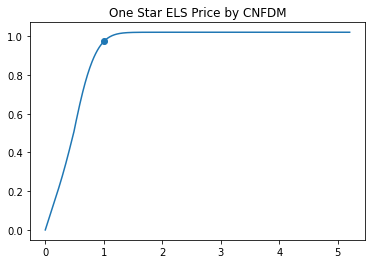

In [46]:
price = ELS_OneStar_CNFDM(xmin, xmax, r, q, sigma, cr, K, B, dt, dx, N, M, x0tag, Rtag, Btag)
print('One-Star ELS CNFDM Price : ', "%.6f" %price[N,x0tag])

#plotting
s = np.linspace(xmin, xmax,M+1)
plt.title('One Star ELS Price by CNFDM')
plt.plot(s,price[N,:])
plt.scatter(s[x0tag],price[N,x0tag])
plt.show()

In [2]:
import numpy as np

In [25]:
# Thomas Algorithm 

def tridiag(a,b,c,d):
    n = d.size
    a1 = a.copy()
    b1 = b.copy()
    c1 = c.copy()
    d1 = d.copy()
    b11 = b1[1:]
    c11 = c1[:-1]
    for i in range(1,n):
        v = b11[i-1]/a1[i-1]
        a1[i] = a1[i] - v * c11[i-1]
        d1[i] = d1[i] - v * d1[i-1]
    w = a1
    w[-1] = d1[-1]/a1[-1]
    
    for j in range(n-2,-1,-1):
        w[j] = (d1[j]-c11[j]*w[j+1]) / a1[j]
        
    return w

def CNFDM(Smax,Smin,vol,r,q,S0,cr,K,B,T,Nx,Nt,Rtag,Btag):
    vol = 0.2803 #상품설명서에 고지된 KOSPI200 지수의 변동성
    q = 0 #배당 없음
    r = 0.02594 #9월 29일자 KOFR 금리
    s0 = 100 #계산의 편의를 위해 KOSPI200의 현재 가격을 100으로 가정
    T = 3 #3년 만기물
    cr = np.array([0.035, 0.07, 0.105, 0.14, 0.175, 0.21])
    K = np.array([0.95, 0.90, 0.85, 0.80, 0.75, 0.75])
    early_redemption = np.array([0.5, 1, 1.5, 2, 2.5, 3])
    d = np.array([0.5, 1, 1.5, 2, 2.5, 3])
    B = 0.5
    dx = 0.01*s0
    h = dx
    Nx = 500
    Smax = dx*Nx
    Smin = 0
    pp = 50
    Nt = 6*pp
    dt = T/Nt
    k = dt
    Rtag = 2*early_redemption*pp
    S0tag = 0
    Btag = 0
    
    a, b, c, d1 = np.zeros(shape=Nx-1), np.zeros(shape=Nx-1), np.zeros(shape=Nx-1) , np.zeros(shape=Nx-1)
    S = np.linspace(Smin,Smax,Nx+1)
    x = S/S0
    u = np.zeros(shape = (Nt + 1, Nx + 1))
    w = np.zeros(shape = (Nt + 1, Nx + 1))

    a, b, c, d1 = np.zeros(shape=Nx-1), np.zeros(shape=Nx-1), np.zeros(shape=Nx-1) , np.zeros(shape=Nx-1)

    for i in range(Nx+1):
        if (i*dx <= S0):
            S0tag = i+1
        else:
            continue
        if (i*dx <= S0 * B):
            Btag = i+1 
        else:
            continue
    a[:] = k / 2 * (r + (vol * S[1:-1] / h) ** 2 )
    b[:] = k / 4 * ( (r * S[1:-1] / h) - (vol * S[1:-1] / h) ** 2 )
    c[:] = k / 4 * ( (-r * S[1:-1] / h) - (vol * S[1:-1] / h) ** 2) 

    for j in range(Nx+1):
    
        if (x[j]>B):
            u[0,j] =(1+cr[5])
        else:
            u[0,j] = x[j]
        if (x[j]>K[5]):
            w[0,j] = (1+cr[5])
        else:
            w[0,j] = x[j]
            
    for i in range(1, Nt+1):
        
        
        d1 = u[i-1,1:Nx]
        d1[0] = -b[0] * u[i,0] + ( 1 - a[0] - 2 * b[0]) * u[i,1] - ( c[0] - b[0] ) * u[i,2] 
        #d1[1:Nx-1] = -b[1:Nx-1] * u[i-1,0:Nx-2] + ( 1 - a[1:Nx-1] ) * u[i-1,1:Nx-1] - ( c[1:Nx-1] ) * u[i-1,2:Nx]
        d1[-1]= (-b[-1]+c[-1]) * u[i-1,Nx-2] + (1 - a[-1] - 2 * c[-1]) * u[i-1,Nx-1] - c[-1] * u[i-1,Nx]
        u[i,1:Nx] = tridiag(1+a,b,c,d1)
        d1 = w[i-1,1:Nx]
        d1[0] = -b[0] * u[i,0] + ( 1 - a[0] - 2 * b[0]) * u[i,1] - ( c[0] - b[0] ) * u[i,2] 
        #d1[1:Nx-1] = -b[1:Nx-1] * u[i-1,0:Nx-2] + ( 1 - a[1:Nx-1] ) * u[i-1,1:Nx-1] - ( c[1:Nx-1] ) * u[i-1,2:Nx]
        d1[-1]= (-b[-1]+c[-1]) * u[i-1,Nx-2] + (1 - a[-1] - 2 * c[-1]) * u[i-1,Nx-1] - c[-1] * u[i-1,Nx]
        w[i,1:Nx] = tridiag(1+a,b,c,d1)
        u[i,1:Btag-1] = w[i,1:Btag-1]
        
        u[i,0] = 2*u[i,1] - u[i,2]
        u[i,-1] = 2*u[i,-2] - u[i,-3]
        w[i,0] = 2*w[i,1] - w[i,2]
        w[i,-1] = 2*w[i,-2] - w[i,-3]
        
        
        for k in range(1,6):
            if (i == Rtag[6-k-1]):
                dummy = S0 * K[6-k-1]
                u[i,int(dummy)-1:] = 1 + cr[6-k-1]
                w[i,int(dummy)-1:] = 1 + cr[6-k-1]

    return u





In [26]:
u=CNFDM(Smax,Smin,vol,r,q,s0,cr,K,B,T,Nx,Nt,Rtag,Btag);

1.1643076322780914

In [36]:
u[-1, 100]

1.1643076322780914

In [27]:
u=CNFDM(Smax,Smin,0.16261,r,q,s0,cr,K,B,T,Nx,Nt,Rtag,Btag); u[-1,100]

1.1643076322780914

In [5]:
def thomas(a,b,c,d):
    """ A is the tridiagnonal coefficient matrix and d is the RHS matrix"""
    N = len(a)
    cp = np.zeros(N,dtype='float64') 
    dp = np.zeros(N,dtype='float64') 
    X = np.zeros(N,dtype='float64')
    
    cp[0] = c[0]/b[0]  
    dp[0] = d[0]/b[0]

    for i in np.arange(1,(N),1):
        dnum = b[i] - a[i]*cp[i-1]
        cp[i] = c[i]/dnum
        dp[i] = (d[i]-a[i]*dp[i-1])/dnum
    
    X[(N-1)] = dp[N-1] 

    for i in np.arange((N-2),-1,-1): 
        X[i] = (dp[i]) - (cp[i])*(X[i+1])
    
    return X

alpha= 6.250
CNFDM Price :  0.4420
Exact BS Price :  0.4420


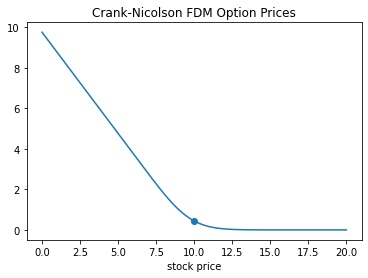

In [10]:
# Example: BS Option Price Using Crank-Nicolson

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


def Thomas_Algorithm(a, b, c, d):

    ne = len(d) # number of equations
    ac, bc, cc, dc = map(np.array, (a, b, c, d)) # copy arrays
    for it in range(1, ne):   
        ac[it] = a[it] - b[it]*(c[it-1]/ac[it-1]) 
        dc[it] = d[it] - b[it]*(dc[it-1]/ac[it-1])

    xc = np.zeros(ne)
    xc[-1] = dc[-1]/ac[-1]
    for il in range(ne-2, -1, -1):
        xc[il] = (dc[il]/ac[il]) - (c[il]/ac[il])*xc[il+1]

    return xc 

def BSprice(PutCall, x0, T, K, rf, q, sigma):
    d1 =(1/(sigma*np.sqrt(T)))*(np.log(x0/K) + (rf - q + 0.5*sigma**2)*T)
    d2 = (1/(sigma*np.sqrt(T)))*(np.log(x0/K) + (rf - q - 0.5*sigma**2)*T)
    Nd1 = norm.cdf(d1)
    Nd2 = norm.cdf(d2)
    Nd1m = norm.cdf(-d1)
    Nd2m = norm.cdf(-d2)
    
    if PutCall == 'C':
        price1 = x0*np.exp(-q*T)*Nd1 - K*np.exp(-rf*T)*Nd2
        price2 = np.exp(-q*T)*Nd1
    elif PutCall =='P':
        price1 = K*np.exp(-rf*T)*Nd2m - x0*np.exp(-q*T)*Nd1m
        price2 = -np.exp(-q*T)*Nd1m

    # price = [price1, price2]=[price,delta]
    price = np.zeros((1,2))
    price[0,0] = price1
    price[0,1] = price2
    return price            


def CNFDMf(PutCall,xmin,K,rf,q,sigma,dt,dx,N,M):
    xh = np.array(list(range(M+1)))                                         # number of node: M+1
    tk = np.array(list(range(N+1)))
    
    v = np.zeros((N+1,M+1))                                                 # solution (shape:(N+1,M+1))
    
    # BC at expiration (n=0)
    if PutCall == 'C':
        v[0,0:M+1] = np.maximum(xmin + xh*dx - K, 0)
    elif PutCall =='P':
        v[0,0:M+1] = np.maximum(K - (xmin + xh*dx), 0)
        
    # BC at x = Smax or Smin (m=M or m=0)
    if PutCall =='C':
        v[0:N+1,0] = 0                                                         # call value when underlying is 0
        v[0:N+1,M] = (xmin + M*dx)*np.exp(-q*tk*dt) - K*np.exp(-rf*tk*dt)      # call value when underlying is large 
    elif PutCall == 'P':
        v[0:N+1,0] = K*np.exp(-rf*tk*dt)                                        # put value when underlying is 0
        v[0:N+1,M] = 0                                                          # put value when underlying is large 

    
    # Coefficients of matrix for CNFDM
    a = (dt/2)*(rf + (sigma**2)*(xh**2))
    b = (dt/4)*((rf-q)*xh - (sigma**2)*(xh**2))
    c = -(dt/4)*((rf-q)*xh + (sigma**2)*(xh**2))

    # a-(b+c)>0, the matrix is strictly diagonally dominant
    d = np.zeros(M+1)
    
    for n in range (0,N):         
        d[1:M] = - np.multiply(b[1:M],v[n,0:M-1]) + np.multiply(1-a[1:M],v[n,1:M]) - np.multiply(c[1:M],v[n,2:M+1])
        d[1] = d[1] - b[1]*v[n+1,0]
        d[M-1] = d[M-1] - c[M-1]*v[n+1,M]       
        v[n+1,1:M] = Thomas_Algorithm(1 + a[1:M],b[1:M],c[1:M],d[1:M])

    price = np.zeros(M+1)
    price = v[N,0:M+1]
    return price

# European Option Pricing
PutCall = 'P'
x0 = 10
K = 10
rf = 0.05
q = 0
sigma = 0.2
T = 0.5

xmax = x0*(1 + 5*sigma)      # five times of annual volatility over half year
xmin = 0
N = 200                       # numer of time point
M = 1000                       # numer of stock price point 
dx = (xmax - xmin)/M           # S-mesh size
dt = T/N                     # t-mesh size
alpha = dt/(dx)**2           # alpha < 1/2 for stability
x0tag = 0
for i in range(M + 1):
    if i*dx < x0:
        x0tag += 1

# Plain Vanillar Option 
CNFDMprice = CNFDMf(PutCall,xmin,K,rf,q,sigma,dt,dx,N,M)

BSEprice = BSprice(PutCall,x0,T,K,rf,q,sigma)

print('alpha=',"%.3f" %alpha)
print('CNFDM Price : ', "%.4f" %CNFDMprice[x0tag])
print('Exact BS Price : ', "%.4f" %BSEprice[0,0])

# Plotting
x = np.linspace(xmin, xmax, M+1)
plt.xlabel('stock price')
plt.title('Crank-Nicolson FDM Option Prices')
plt.plot(x, CNFDMprice[:])
plt.scatter(x[x0tag], CNFDMprice[x0tag])
plt.show()

# 백업


In [ ]:
sigma = 0.2803 #상품설명서에 고지된 KOSPI200 지수의 변동성
q = 0.0222 #배당 없음
r = 0.0279 #22/8 91 CD 금리
x0 = 1 #계산의 편의를 위해 KOSPI200의 현재 가격을 100으로 가정
F = 100
T = 3 #3년 만기물
cr = np.array([0.035, 0.07, 0.105, 0.14, 0.175, 0.21])
K = np.array([0.95, 0.90, 0.85, 0.80, 0.75, 0.75])
early_redemption = np.array([0.5, 1, 1.5, 2, 2.5, 3])
d = np.array([0.5, 1, 1.5, 2, 2.5, 3])
B = 0.5

smin = 0
smax = x0*(1 + T*5*sigma)
dx = 0.01 #간격
M = round((smax - smin)/dx)

pp = 50 #num of time point
N = 6 * pp
dt = T/N
Rtag = list(2 * pp * np.array(d))

xh = np.arange(M+1)
x = np.round(xh*dx,-int(np.log10(dx)))

x0tag = np.where(x==x0)[0][0]
Btag = np.where(x==B)[0][0]